# Sistema para exibir, manipular e salvar imagens

### *Integrantes:*
- Júlia Moraes
- Luiz Eduardo
- Pedro Miguel Cecato
- Pedro Lucas Simões
- Humberto Nunes

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Tarefas 

*Trio*
- Leitura e Salvamento 
- Filtros - (sobel (abs -> histograma))

*Dupla*
- Equalização
- Documento 



#### Classe para manipulação de imagens

In [19]:
class Image_Manipulation:
    def __init__(self, caminho_imagem):
        self.caminho_imagem = caminho_imagem
        self.imagem_atual = self.extrair_pixels_rgb()  # já inicializa carregando a imagem

    def extrair_pixels_rgb(self):
        img = Image.open(self.caminho_imagem)
        img = img.convert('RGB')
        pixels = np.array(img, dtype=np.uint8)
        return pixels

    def salvar_imagem(self, caminho_saida):
        """
        Salva a imagem atual como arquivo RGB.
        """
        img = Image.fromarray(self.imagem_atual, 'RGB')
        img.save(caminho_saida)

    def exibir_imagem(self, titulo="Imagem"):
        plt.figure(figsize=(10, 8))
        plt.imshow(self.imagem_atual)
        plt.title(titulo)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def equalizacao(self):
        """
        Aplica equalização de histograma global em cada canal RGB.
        """
        L = 256
        resultado = np.zeros_like(self.imagem_atual)
        rows, cols = self.imagem_atual.shape[0], self.imagem_atual.shape[1]
        RC = rows * cols

        for canal in range(3):
            canal_img = self.imagem_atual[:, :, canal]
            hist, _ = np.histogram(canal_img.flatten(), bins=L, range=[0, L])
            cdf = hist.cumsum()
            transformacao = np.round((L - 1) * cdf / RC).astype(np.uint8)
            resultado[:, :, canal] = transformacao[canal_img]

        self.imagem_atual = resultado
        return self.imagem_atual

    def ler_filtro(self, arquivo):
        """
        Lê filtro, bias e ativação de um arquivo txt.
        """
        with open(arquivo, 'r') as f:
            linhas = f.readlines()
        mascara = []
        bias = 0
        ativacao = 'identidade'
        for linha in linhas:
            if linha.startswith('mascara:'):
                continue
            elif linha.startswith('bias:'):
                bias = int(linha.split(':')[1].strip())
            elif linha.startswith('ativacao:'):
                ativacao = linha.split(':')[1].strip().lower()
            elif linha.strip():
                mascara.append([int(x) for x in linha.strip().split()])
        return np.array(mascara), bias, ativacao

    def ativacao_relu(self, x):
        return np.maximum(0, x)

    def ativacao_identidade(self, x):
        return x

    def correlacao_manual(self, mascara, bias, ativacao):
        """
        Aplica correlação 2D com máscara m x n em cada canal RGB.
        """
        imagem = self.imagem_atual
        altura, largura, canais = imagem.shape
        m, n = mascara.shape
        pad_h = m // 2
        pad_w = n // 2
        resultado = np.zeros_like(imagem, dtype=np.int32)

        # pad nas bordas
        imagem_padded = np.pad(imagem, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='edge')

        for canal in range(canais):
            for i in range(altura):
                for j in range(largura):
                    regiao = imagem_padded[i:i+m, j:j+n, canal]
                    valor = np.sum(regiao * mascara) + bias
                    if ativacao == 'relu':
                        resultado[i, j, canal] = self.ativacao_relu(valor)
                    else:
                        resultado[i, j, canal] = self.ativacao_identidade(valor)

        self.imagem_atual = np.clip(resultado, 0, 255).astype(np.uint8)
        return self.imagem_atual

    def visualizar_sobel(self):
        """
        Aplica valor absoluto + expansão de histograma [0, 255] (pós-Sobel).
        """
        img_abs = np.abs(self.imagem_atual)
        r_min = np.min(img_abs)
        r_max = np.max(img_abs)

        if r_max > r_min:
            img_expandida = ((img_abs - r_min) / (r_max - r_min) * 255)
        else:
            img_expandida = img_abs

        self.imagem_atual = img_expandida.astype(np.uint8)
        return self.imagem_atual


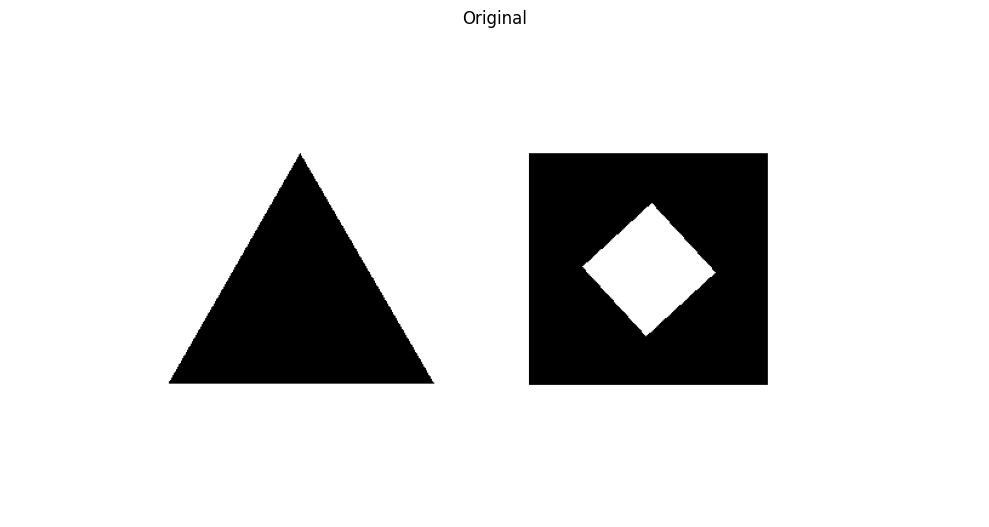

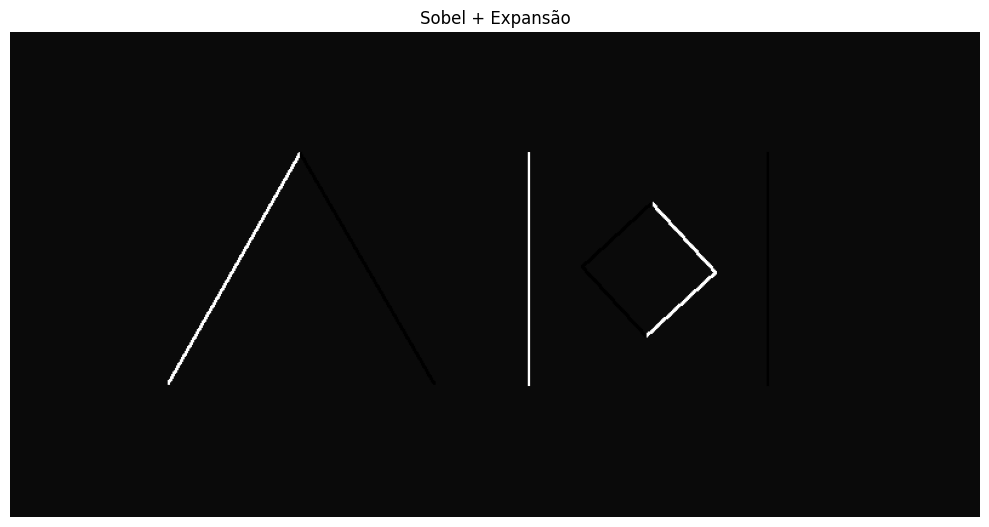

In [21]:
img_manip = Image_Manipulation("../imagens/Shapes.png")
img_manip.exibir_imagem("Original")

# aplicar filtro Sobel
mascara, bias, ativ = img_manip.ler_filtro("../filtro.txt")
img_manip.correlacao_manual(mascara, bias, ativ)
img_manip.visualizar_sobel()
img_manip.exibir_imagem("Sobel + Expansão")

In [4]:
def salvar_imagem(imagem_array, caminho_saida):
    """
    Salva um array NumPy como imagem RGB em disco.
    """
    img = Image.fromarray(imagem_array, 'RGB')
    img.save(caminho_saida)

In [5]:
def extrair_pixels_rgb(caminho_imagem):
    img = Image.open(caminho_imagem)
    img = img.convert('RGB')
    pixels = np.array(img, dtype=np.uint8)
    return pixels


def equalizacao(imagem):
    """
    Aplica equalização de histograma usando a fórmula:
    T(r) = round( (L-1) / (RC) × Σ nₗ )
    
    Onde:
    L = 256 (níveis de intensidade)
    RC = número total de pixels (linhas × colunas)
    Σ nₗ = soma acumulada das frequências (CDF)
    """
    # Níveis de intensidade
    L = 256
    
    if len(imagem.shape) == 3:
        # Para imagens RGB - processa cada canal separadamente
        resultado = np.zeros_like(imagem)
        rows, cols = imagem.shape[0], imagem.shape[1]
        RC = rows * cols  # Número total de pixels
        
        for canal in range(3):
            canal_img = imagem[:, :, canal]
            
            # Calcula o histograma (nₗ)
            hist, _ = np.histogram(canal_img.flatten(), bins=L, range=[0, L])
            
            # Calcula a soma acumulada (Σ nₗ)
            cdf = hist.cumsum()
            
            # Aplica a fórmula: T(r) = round( (L-1) / RC × Σ nₗ )
            transformacao = np.round((L - 1) * cdf / RC).astype(np.uint8)
            
            # Aplica a transformação em todos os pixels
            resultado[:, :, canal] = transformacao[canal_img]
            
        return resultado
    
def exibir_imagem(imagem, titulo="Imagem"):
    plt.figure(figsize=(10, 8))
    plt.imshow(imagem)
    plt.title(titulo)
    plt.axis('off')
    plt.tight_layout()
    plt.show()



In [8]:
imagem_eq = equalizacao(extrair_pixels_rgb('../imagens/CobblestoneBrickCityAlley_byBrunoPassigatti.jpg'))

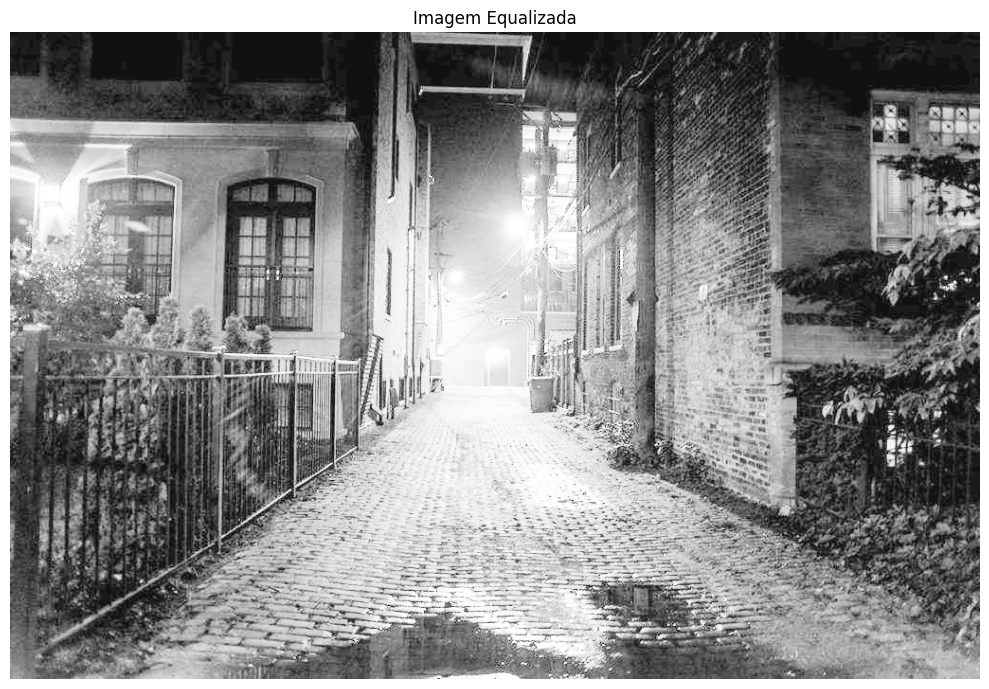

In [10]:
exibir_imagem(imagem_eq, titulo="Imagem Equalizada")


In [11]:
def ler_filtro(arquivo):
    with open(arquivo, 'r') as f:
        linhas = f.readlines()
    mascara = []
    bias = 0
    ativacao = 'identidade'
    for linha in linhas:
        if linha.startswith('mascara:'):
            continue
        elif linha.startswith('bias:'):
            bias = int(linha.split(':')[1].strip())
        elif linha.startswith('ativacao:'):
            ativacao = linha.split(':')[1].strip().lower()
        elif linha.strip():
            mascara.append([int(x) for x in linha.strip().split()])
    return np.array(mascara), bias, ativacao

In [12]:
def ativacao_relu(x):
    return np.maximum(0, x)

def ativacao_identidade(x):
    return x


In [13]:
def correlacao_manual(imagem, mascara, bias, ativacao):
    # imagem: array (altura, largura, 3)
    # mascara: array (m, n)
    altura, largura, canais = imagem.shape
    m, n = mascara.shape
    pad_h = m // 2
    pad_w = n // 2
    resultado = np.zeros_like(imagem, dtype=np.int32)
    
    # Pad na imagem para bordas
    imagem_padded = np.pad(imagem, ((pad_h, pad_h), (pad_w, pad_w), (0,0)), mode='edge')
    
    for canal in range(canais):
        for i in range(altura):
            for j in range(largura):
                # Extrai região
                regiao = imagem_padded[i:i+m, j:j+n, canal]
                valor = np.sum(regiao * mascara) + bias
                if ativacao == 'relu':
                    resultado[i, j, canal] = ativacao_relu(valor)
                else:
                    resultado[i, j, canal] = ativacao_identidade(valor)
    # Limita valores para faixa válida
    resultado = np.clip(resultado, 0, 255).astype(np.uint8)
    return resultado

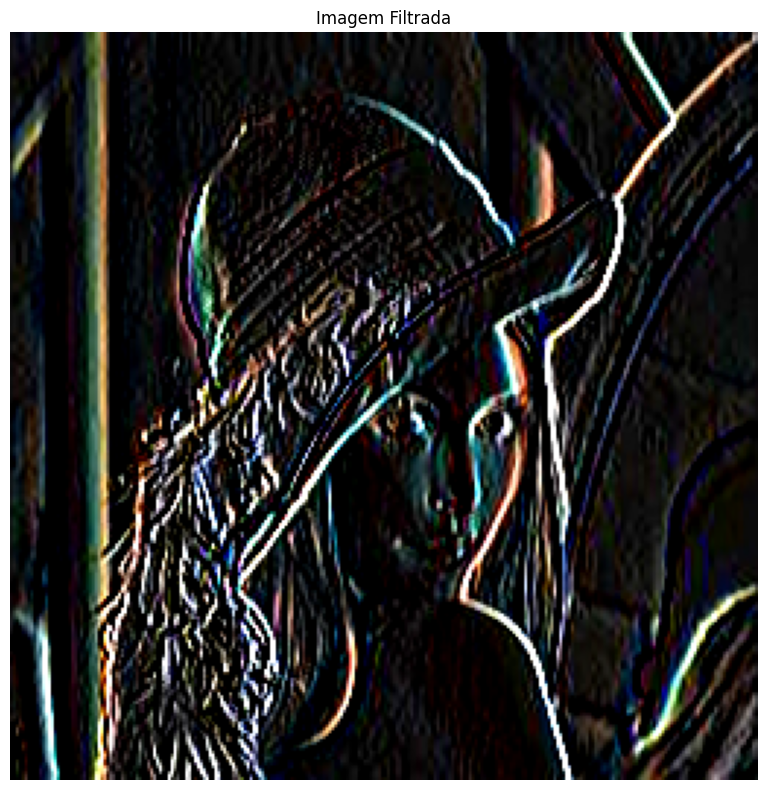

In [16]:
mascara, bias, ativacao = ler_filtro('../filtro.txt')
imagem = extrair_pixels_rgb('../imagens/lena256color.jpg')
imagem_filtrada = correlacao_manual(imagem, mascara, bias, ativacao)
exibir_imagem(imagem_filtrada, titulo="Imagem Filtrada")

In [17]:
#chamar passando uma imagem que ja tenha passado por um filtro
def visualizar_sobel(img_sobel):
    #valor absoluto
    img_abs = np.abs(img_sobel)

    #expansão de histograma
    r_min = np.min(img_abs)
    r_max = np.max(img_abs)

    if r_max > r_min:
        img_expandida = ((img_abs - r_min) / (r_max - r_min) * 255)
    else:
        img_expandida = img_abs  # caso onde todos os valores são iguais

    return img_expandida.astype(np.uint8)

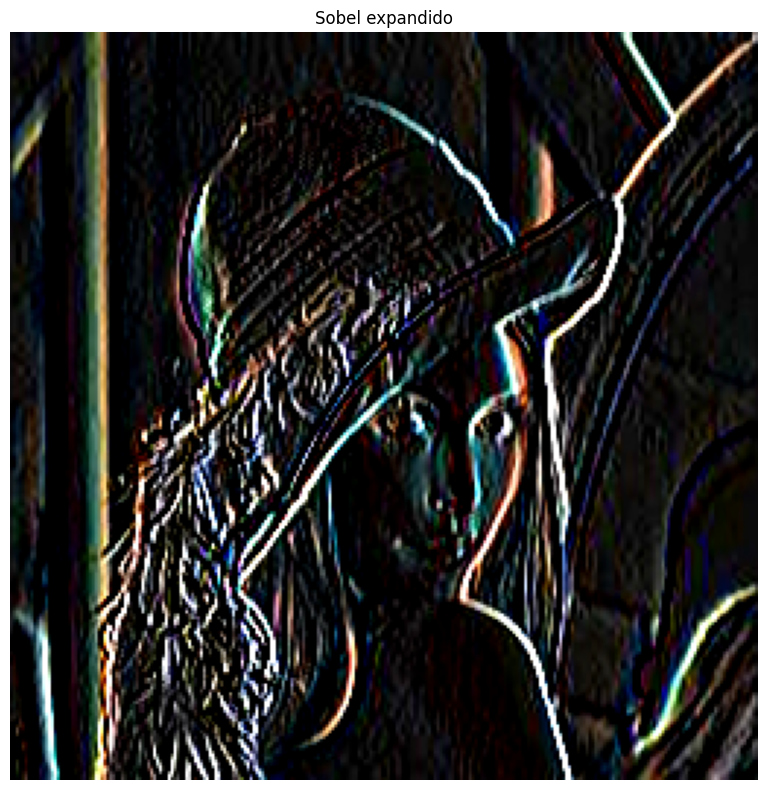

In [18]:
imagem_sobel_vis = visualizar_sobel(imagem_filtrada)
exibir_imagem(imagem_sobel_vis, titulo="Sobel expandido")